In order to run: <br>
(1) unzip the submit dataset and put the resulting csv files into the submit folder in the repository <br>
(2) Make sure you have all the required packages including pyomo installed <br>
(3) Make sure cplex is installed and set the path to the executable file <br>
This post goes along with the notebook: http://energystoragesense.com/uncategorized/scheduling_batt_optimisation/

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en
import seaborn as sns
from __future__ import division
import time

%matplotlib inline

In [2]:
# set up seaborn the way you like
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})

In [3]:
# Since using the data-driven data for the testing, use their battery class
from battery import Battery

read in the data and choose a site that we want to work with <br>
all data should be unzipped and put in a folder called data in the parent directory <br>
the metadata file containing the site ids and information about each site's batteries is located in the parent dir also

In [4]:
metadata = pd.read_csv('./metadata.csv', index_col=0)

In [5]:
# lets have a look at what the data looks like for each site
metadata.head(n=2)

,Battery_1_Capacity,Battery_1_Power,Battery_1_Charge_Efficiency,Battery_1_Discharge_Efficiency,Battery_2_Capacity,Battery_2_Power,Battery_2_Charge_Efficiency,Battery_2_Discharge_Efficiency
SiteId,,,,,,,,
1,300,75.0,0.95,0.95,600,150,0.95,0.95
2,600,150.0,0.95,0.95,1200,300,0.95,0.95


Let's use the data from site 1 in our test, so we use siteId==1 and the metadata where the siteId==1

In [6]:
#### CHNAGE THE SITE ID HERE
site_id = 1
parameters = metadata.loc[site_id]

We see that the metadata parameters contains information about two batteries and we only run one at a time <br>
Therefore we need to specify a battery id and we use the battery class to store information about the battery characteristics <br>
**NOTE:** <br>
the metadata info is in kWh and the battery class wants information in Wh (convention from data driven) <br>
This could be easily changed but we will keep the convention from the competition data

In [7]:
batt_id = 1
# use battery class to store information
batt = Battery(capacity=parameters["Battery_"+str(batt_id)+"_Capacity"]*1000,
           charging_power_limit=parameters["Battery_"+str(batt_id)+"_Power"]*1000,
           discharging_power_limit=-parameters["Battery_"+str(batt_id)+"_Power"]*1000,
           charging_efficiency=parameters["Battery_"+str(batt_id)+"_Charge_Efficiency"],
           discharging_efficiency=parameters["Battery_"+str(batt_id)+"_Discharge_Efficiency"])

In [8]:
# read the testdata
testData = pd.read_csv('./submit/'+str(site_id)+'.csv',parse_dates=['timestamp'],index_col='timestamp')

In [9]:
# have a quick look at the testdata
testData.head()

,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,load_05,...,price_sell_86,price_sell_87,price_sell_88,price_sell_89,price_sell_90,price_sell_91,price_sell_92,price_sell_93,price_sell_94,price_sell_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-28 18:30:00,1,1,81176.130689,6.402769,83386.197008,67843.948781,70048.152840,59642.545109,60188.215290,59636.176826,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 18:45:00,1,1,80605.617963,0.000000,66806.077292,69982.725988,60119.750077,60968.213117,60585.135468,55973.870854,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:00:00,1,1,77078.004926,0.000000,74941.447951,62113.661139,61307.736184,60001.496914,54875.100794,59214.994539,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:15:00,1,1,74512.777194,0.000000,64251.265034,64877.341687,64370.170671,59689.660974,64278.362879,59704.464278,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:30:00,1,1,63425.490620,0.000000,63461.184833,62624.575734,57760.236973,62246.360804,57615.222824,56206.744732,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031


In [10]:
# let's look at the period ids to see how many periods there are
np.unique(testData['period_id'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [11]:
for g_id, g_df in testData.groupby('period_id'):
    days = []
    for ts in g_df.index:
        day = str(ts.day)+'/'+str(ts.month)
        if day not in days:
            days.append(day)         
    print g_id, days

1 ['28/8', '29/8', '30/8', '31/8', '1/9', '2/9', '3/9', '4/9', '5/9', '6/9', '7/9']
2 ['2/5', '3/5', '4/5', '5/5', '6/5', '7/5', '8/5', '9/5', '10/5', '11/5', '12/5']
3 ['25/8', '26/8', '27/8', '28/8', '29/8', '30/8', '31/8', '1/9', '2/9', '3/9', '4/9']
4 ['24/10', '25/10', '26/10', '27/10', '28/10', '29/10', '30/10', '31/10', '1/11', '2/11', '3/11']
5 ['18/2', '19/2', '20/2', '21/2', '22/2', '23/2', '24/2', '25/2', '26/2', '27/2', '28/2']
6 ['18/4', '19/4', '20/4', '21/4', '22/4', '23/4', '24/4', '25/4', '26/4', '27/4', '28/4']
7 ['31/1', '1/2', '2/2', '3/2', '4/2', '5/2', '6/2', '7/2', '8/2', '9/2', '10/2']
8 ['1/4', '2/4', '3/4', '4/4', '5/4', '6/4', '7/4', '8/4', '9/4', '10/4', '11/4']
9 ['31/5', '1/6', '2/6', '3/6', '4/6', '5/6', '6/6', '7/6', '8/6', '9/6', '10/6']
10 ['22/10', '23/10', '24/10', '25/10', '26/10', '27/10', '28/10', '29/10', '30/10', '31/10', '1/11']


We can see from the above that each period contains 10 consective days <br>
We will actually run the optimisation for one period at a time

In [12]:
# lets take a look at one period
for g_id, g_df in testData.groupby('period_id'):
    break
    
g_df.head()

,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,load_05,...,price_sell_86,price_sell_87,price_sell_88,price_sell_89,price_sell_90,price_sell_91,price_sell_92,price_sell_93,price_sell_94,price_sell_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-28 18:30:00,1,1,81176.130689,6.402769,83386.197008,67843.948781,70048.152840,59642.545109,60188.215290,59636.176826,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 18:45:00,1,1,80605.617963,0.000000,66806.077292,69982.725988,60119.750077,60968.213117,60585.135468,55973.870854,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:00:00,1,1,77078.004926,0.000000,74941.447951,62113.661139,61307.736184,60001.496914,54875.100794,59214.994539,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:15:00,1,1,74512.777194,0.000000,64251.265034,64877.341687,64370.170671,59689.660974,64278.362879,59704.464278,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-28 19:30:00,1,1,63425.490620,0.000000,63461.184833,62624.575734,57760.236973,62246.360804,57615.222824,56206.744732,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031


We see the structure of the data (which we could have also seen from the testData dataframe) <br>
Each 15 minute has <br>
an actual consumption (which is the consumption from the previous 15 mins) <br>
actual pv production (again from the previous 15 mins) <br>
a load_forecast (where load_00 is the forecast for the next 15 mins) <br>
a pv forecast (where pv_00 is the forecast for the next 15 mins) <br>
a buy price for electricity for the next 96 periods (price_buy_00 is the price for the next 15 mins) <br>
a sell price for electricity for the next 96 periods (price_sell_00 is the price for the next 15 mins) <br>

In [13]:
# first we shift the consumption so it is aligned with the actual period and not the previous period
# this is also done in the competition
g_df.loc[:, 'actual_consumption'] = g_df.actual_consumption.shift(-1)
g_df.loc[:, 'actual_pv'] = g_df.actual_pv.shift(-1)

Now, let's use the data provided to work out the maximum possible saving provided by the battery <br>
We will use data from the actual_consumption, actual_pv, price_sell_00 and price_buy_00 columns <br>

In [14]:
# here convert the various timeseries to numpy arrays
# replace these with the arrays from the site you want to model
load = g_df['actual_consumption'].values
PV = g_df['actual_pv'].values
sellPrice = g_df['price_sell_00'].values
buyPrice = g_df['price_buy_00'].values

# since the last values are nan after the shift we will shorten the arrays
# shorten the arrays so the price and actual line up
load = load[0:-1]
PV = PV[0:-1]
sellPrice = sellPrice[0:-1]
buyPrice = buyPrice[0:-1]

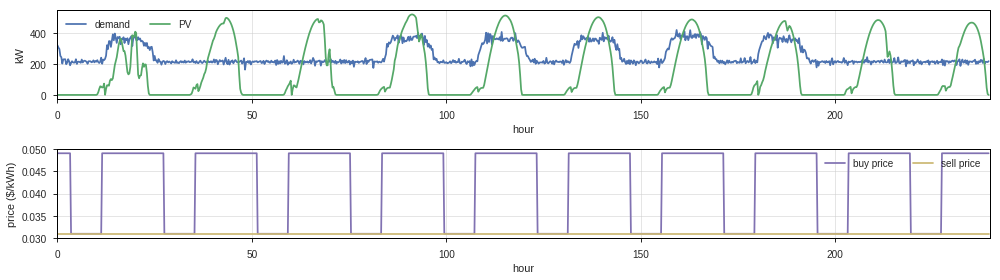

In [15]:
colors = sns.color_palette()
hrs = np.arange(0,len(load))/4
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(2,1,1)
l1, = ax1.plot(hrs,4*load/1000,color=colors[0])
l2, = ax1.plot(hrs,4*PV/1000,color=colors[1])
ax1.set_xlabel('hour'), ax1.set_ylabel('kW')
ax1.legend([l1,l2],['demand','PV'],ncol=2)
ax1.set_xlim([0,len(load)/4]);
ax2 = fig.add_subplot(2,1,2)
l1, = ax2.plot(hrs,buyPrice,color=colors[3])
l2, = ax2.plot(hrs,sellPrice,color=colors[4])
ax2.set_xlabel('hour'), ax2.set_ylabel('price ($/kWh)')
ax2.legend([l1,l2],['buy price','sell price'],ncol=2)
ax2.set_xlim([0,len(load)/4]);
fig.tight_layout()

### We are now ready to schedule the battery using pyomo!

First of all, pyomo uses indexed variables, therefore we create these using dictionaries

In [16]:
priceDict1 = dict(enumerate(sellPrice))
priceDict2 = dict(enumerate(buyPrice))

The net is the consumers load+PV <br>
The way that the price is formulated is that if the net is greater than 0, then the consumer is buying from the grid and electricity costs the buy_price <br>
If the net is less than 0, then the consumer is selling electricity to the grid and the electricity is sold at price_sell <br>
Therefore, we split the net into positive (buying) and negative (selling) load

In [17]:
net = load-PV
# split load into +ve and -ve
posLoad = np.copy(load-PV)
negLoad = np.copy(load-PV)
for j,e in enumerate(net):
    if e>=0:
        negLoad[j]=0
    else:
        posLoad[j]=0
posLoadDict = dict(enumerate(posLoad))
negLoadDict = dict(enumerate(negLoad))

In [18]:
# now set up the pyomo model
m = en.ConcreteModel()

# we use rangeset to make a sequence of integers
# time is what we will use as the model index
m.Time = en.RangeSet(0, len(net)-1)

#### Variables
Now we define the variables that we are interested in: <br>
We formulate the problem such that our decision variables are *posNetLoad* and *negNetLoad* <br>
See the objective fn.

In [19]:
# variables (all indexed by Time)
m.SOC = en.Var(m.Time, bounds=(0,batt.capacity), initialize=0) #0
m.posDeltaSOC = en.Var(m.Time, initialize=0) #1
m.negDeltaSOC = en.Var(m.Time, initialize=0) #2
m.posEInGrid = en.Var(m.Time, bounds=(0,batt.charging_power_limit*(15/60.)), initialize=0) #3
m.posEInPV = en.Var(m.Time, bounds=(0,batt.charging_power_limit*(15/60.)), initialize=0) #4
m.negEOutLocal = en.Var(m.Time, bounds=(batt.discharging_power_limit*(15/60.),0), initialize=0) #5
m.negEOutExport = en.Var(m.Time, bounds=(batt.discharging_power_limit*(15/60.),0), initialize=0) #6
m.posNetLoad = en.Var(m.Time, initialize=posLoadDict) #7
m.negNetLoad = en.Var(m.Time, initialize=negLoadDict) #8

The numbers commented after are the indices that we will use when looping through the model components afterwards to get the final values of the variables after the optimisation has been completed

The Boolean variables are what we will use to denote whether the battery is charging or discharging at a particular period

In [20]:
# Boolean variables (again indexed by Time)
m.Bool_char=en.Var(m.Time,within=en.Boolean) #9
m.Bool_dis=en.Var(m.Time,within=en.Boolean,initialize=0) #10

In [21]:
# parameters (indexed by time)
m.priceSell = en.Param(m.Time, initialize=priceDict1)
m.priceBuy = en.Param(m.Time, initialize=priceDict2)
m.posLoad = en.Param(m.Time, initialize=posLoadDict)
m.negLoad = en.Param(m.Time, initialize=negLoadDict)

In [22]:
# single value parameters
m.etaChg = en.Param(initialize = batt.charging_efficiency)
m.etaDisChg = en.Param(initialize = batt.discharging_efficiency)
m.ChargingLimit = en.Param(initialize = batt.charging_power_limit*(15/60.))
m.DischargingLimit = en.Param(initialize = batt.discharging_power_limit*(15/60.))

#### Objective function 
Now define the objective function that we are going to minimise (the cost of the site's electricity)

In [23]:
# objective function
def Obj_fn(m):
    return sum((m.priceBuy[i]*m.posNetLoad[i]) + (m.priceSell[i]*m.negNetLoad[i]) for i in m.Time)  
m.total_cost = en.Objective(rule=Obj_fn,sense=en.minimize)

In the above posNetLoad and negNetLoad are variables, indexed by time that will change dependent on the action of the battery <br>
They have initially been assigned using posLoad and negLoad, which correspond to no battery action

We now need to think about the constraints on the model. First of all, we add a constraint which represents the finite physical capacity of the battery, which cannot be above the maximum and cannot fall below zero

In [24]:
# constraints
# first we define the constraint at each time period
def SOC_rule(m,t):
    if t==0:
        return (m.SOC[t] == m.posDeltaSOC[t]+m.negDeltaSOC[t])
    else:
        return (m.SOC[t] == m.SOC[t-1]+m.posDeltaSOC[t]+m.negDeltaSOC[t])   
# then we specify that this constraint is indexed by time
m.Batt_SOC = en.Constraint(m.Time,rule=SOC_rule)

#### boolean constraints - the integers
The next set of constraints is the "Integer" part in the Mixed Integer Linear Program formulation. <br>
These constraints explicitly constrain that the battery can only charge OR discharge during one time period <br>
The observant might notice that in this specific example, these constraints aren't actually required, since in our objective function there will never be an economic benefit to this type of action <br>
However, it is good to see how they are set up, they can make the optimisation faster and many cases they are required

In [25]:
# we use bigM to bound the problem
# boolean constraints
def Bool_char_rule_1(m,i):
    bigM=500000
    return((m.posDeltaSOC[i])>=-bigM*(m.Bool_char[i]))
m.Batt_ch1=en.Constraint(m.Time,rule=Bool_char_rule_1)
# if battery is charging, charging must be greater than -large
# if not, charging geq zero
def Bool_char_rule_2(m,i):
    bigM=500000
    return((m.posDeltaSOC[i])<=0+bigM*(1-m.Bool_dis[i]))
m.Batt_ch2=en.Constraint(m.Time,rule=Bool_char_rule_2)
# if batt discharging, charging must be leq zero
# if not, charging leq +large
def Bool_char_rule_3(m,i):
    bigM=500000
    return((m.negDeltaSOC[i])<=bigM*(m.Bool_dis[i]))
m.Batt_cd3=en.Constraint(m.Time,rule=Bool_char_rule_3)
# if batt discharge, discharge leq POSITIVE large
# if not, discharge leq 0
def Bool_char_rule_4(m,i):
    bigM=500000
    return((m.negDeltaSOC[i])>=0-bigM*(1-m.Bool_char[i]))
m.Batt_cd4=en.Constraint(m.Time,rule=Bool_char_rule_4)
# if batt charge, discharge geq zero
# if not, discharge geq -large
def Batt_char_dis(m,i):
    return (m.Bool_char[i]+m.Bool_dis[i],1)
m.Batt_char_dis=en.Constraint(m.Time,rule=Batt_char_dis)

bigM is a big number to bound the problem...
Here is a link from an MIT open course: https://ocw.mit.edu/courses/sloan-school-of-management/15-053-optimization-methods-in-management-science-spring-2013/tutorials/MIT15_053S13_tut09.pdf

#### battery efficiency
The next constraints deal with the battery efficiency: <br>
We ensure that any change in the battery in the battery's state of charge at a particular period due to charging is reduced by the charging efficieny <br>
Similarly, we ensure that the energy output from the battery is reduced when it is converted to an output

In [26]:
#ensure charging efficiency is divided
def pos_E_in_rule(m,i):
    return (m.posEInGrid[i]+m.posEInPV[i]) == m.posDeltaSOC[i]/m.etaChg
m.posEIn_cons = en.Constraint(m.Time, rule=pos_E_in_rule)
# ensure discharging eff multiplied
def neg_E_out_rule(m,i):
    return (m.negEOutLocal[i]+m.negEOutExport[i]) == m.negDeltaSOC[i]*m.etaDisChg
m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)

#### Charging and discharging power limits
Now ensure that the charging and discharging power limits of the battery are respected. <br>
Note that we have opted to split the energy into that coming-from the grid (posEInGrid), going-to the grid (negEOutExport), coming from local PV (posEInPV) and being used locally (negEOutLocal)

In [27]:
# ensure charging rate obeyed
def E_charging_rate_rule(m,i):
    return (m.posEInGrid[i]+m.posEInPV[i])<=m.ChargingLimit
m.chargingLimit_cons = en.Constraint(m.Time, rule=E_charging_rate_rule)
# ensure DIScharging rate obeyed
def E_discharging_rate_rule(m,i):
    return (m.negEOutLocal[i]+m.negEOutExport[i])>=m.DischargingLimit
m.dischargingLimit_cons = en.Constraint(m.Time, rule=E_discharging_rate_rule)

#### Further constraints to ensure physical sense

In [28]:
# ensure that posEInPV cannot exceed local PV
def E_solar_charging_rule(m,i):
    return m.posEInPV[i]<=-m.negLoad[i]
m.solarChargingLimit_cons = en.Constraint(m.Time, rule=E_solar_charging_rule)
# ensure that negEOutLocal cannot exceed local demand
def E_local_discharge_rule(m,i):
    return m.negEOutLocal[i]>=-m.posLoad[i]
m.localDischargingLimit_cons = en.Constraint(m.Time, rule=E_local_discharge_rule)

#### Rules for actually calculating the main decision variables

In [29]:
# calculate the net positive demand
def E_pos_net_rule(m,i):
    return m.posNetLoad[i] == m.posLoad[i]+m.posEInGrid[i]+m.negEOutLocal[i]
m.E_posNet_cons = en.Constraint(m.Time,rule=E_pos_net_rule)

# calculate export
def E_neg_net_rule(m,i):
    return m.negNetLoad[i] == m.negLoad[i]+m.posEInPV[i]+m.negEOutExport[i]
m.E_negNet_cons = en.Constraint(m.Time,rule=E_neg_net_rule)

#### Running pyomo
Now we just need to get pyomo to run, so first we need to specify the path to the solver:

In [30]:
# set the path to the solver
# SPECIFY YOUR OWN PATH TO CPLEX OR WHATEVER OTHER SOLVER
opt = SolverFactory("cplex", executable="/opt/ibm/ILOG/CPLEX_Studio1271/cplex/bin/x86-64_linux/cplex")

#### Now we can run 

In [31]:
# time it for good measure
t = time.time()
results = opt.solve(m)
elapsed = time.time() - t
print 'Time elapsed:', elapsed

Time elapsed: 1.71598100662


#### Reading the outputs
I prefer having my outputs as numpy arrays, as I am more used to them <br>
Remember the order in which we defined the variables? Well that's the way that pyomo spits them out. Hence we numbered the variables as we declared them <br>
I find it easiest to just loop through the variables and store the ones that we are interested in

In [32]:
j = 0
for v in m.component_objects(Var, active=True):
    print j, v.getname()
    j+=1

0 SOC
1 posDeltaSOC
2 negDeltaSOC
3 posEInGrid
4 posEInPV
5 negEOutLocal
6 negEOutExport
7 posNetLoad
8 negNetLoad
9 Bool_char
10 Bool_dis


In [33]:
# now let's read in the value for each of the variables 
outputVars = np.zeros((9,len(sellPrice)))

In [34]:
j = 0
for v in m.component_objects(Var, active=True):
    print v.getname()
    #print varobject.get_values()
    varobject = getattr(m, str(v))
    for index in varobject:
        outputVars[j,index] = varobject[index].value
    j+=1
    if j>=9:
        break

SOC
posDeltaSOC
negDeltaSOC
posEInGrid
posEInPV
negEOutLocal
negEOutExport
posNetLoad
negNetLoad


The above cell is the solution, but we can also calculate how much better this new solution is than the no battery case (or any other battery action that you may consider)

In [35]:
posLoad[0]

80605.617962847129

I guess the prices are in dollars per kWh and at the moment everything is in Wh...

In [36]:
# get the total cost
cost_without_batt = np.sum([(buyPrice[i]*posLoad[i]/1000 + sellPrice[i]*negLoad[i]/1000) for i in range(len(buyPrice))])
cost_with_batt = np.sum([(buyPrice[i]*outputVars[7,i]/1000 + sellPrice[i]*outputVars[8,i]/1000) for i in range(len(buyPrice))])

print 'Cost without battery:', cost_without_batt
print 'Cost with battery:', cost_with_batt
print 'Score: %.4f'%((cost_with_batt - cost_without_batt) / np.abs(cost_without_batt))

Cost without battery: 1233.09290119
Cost with battery: 1159.1322435
Score: -0.0600


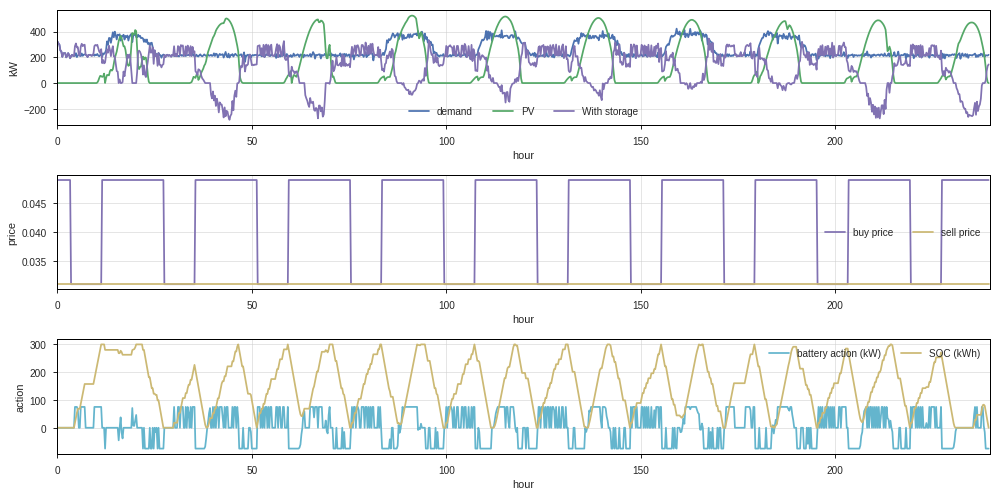

In [37]:
newNetLoad = outputVars[7]+outputVars[8]
# lets look at the results
colors = sns.color_palette()
hrs = np.arange(0,len(load))/4
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(3,1,1)
l1, = ax1.plot(hrs,4*load/1000,color=colors[0])
l2, = ax1.plot(hrs,4*PV/1000,color=colors[1])
l3, = ax1.plot(hrs, 4*newNetLoad/1000,color=colors[3])
ax1.set_xlabel('hour'), ax1.set_ylabel('kW')
ax1.legend([l1,l2,l3],['demand','PV','With storage'],ncol=3)
ax1.set_xlim([0,len(load)/4]);
ax2 = fig.add_subplot(3,1,2)
l1, = ax2.plot(hrs,buyPrice,color=colors[3])
l2, = ax2.plot(hrs,sellPrice,color=colors[4])
ax2.set_xlabel('hour'), ax2.set_ylabel('price')
ax2.legend([l1,l2],['buy price','sell price'],ncol=2)
ax2.set_xlim([0,len(load)/4]);
ax3 = fig.add_subplot(3,1,3)
l1, = ax3.plot(hrs,np.sum(outputVars[3:7,:]*4/1000, axis=0),color=colors[5])
l2, = ax3.plot(hrs,outputVars[0]/1000,color=colors[4])
ax3.set_xlabel('hour'), ax3.set_ylabel('action')
ax3.legend([l1,l2],['battery action (kW)','SOC (kWh)'],ncol=2)
ax3.set_xlim([0,len(load)/4]);
fig.tight_layout()

Now compare to alternate formulation

In [38]:
def battery_scheduler(batt, loadForecast, pvForecast, priceBuy, priceSell):

    seriesLength=len(loadForecast)

    ### ------------------------- ESS properties ----------------- ###
    maxSOC = batt.capacity # Units are Wh
    maxChg = batt.charging_power_limit/4. # W
    maxDisChg = batt.discharging_power_limit/4. # W
    etaChg = batt.charging_efficiency
    etaDisChg = batt.discharging_efficiency
    ### ---------------------------------------------------------- ###
    expectedExports = np.zeros((seriesLength)) 

    net = loadForecast-pvForecast          
    expectedExports[net<0] = -net[net<0]

    # now alter the price in the periods where there is solar available (if req.)
    priceCharge = np.copy(priceBuy)
    priceCharge[net<0] = priceSell[net<0]
    priceDischarge = np.copy(priceSell)
    priceDischarge[net>0] = priceBuy[net>0]

    # get the storage profiles
    SOC = np.zeros((seriesLength))
    deltaSOC = np.zeros((seriesLength))

    # boolean variables for charging/discharging availability
    removeMINH = np.ones((seriesLength))
    removeMAXH = np.ones((seriesLength))

    demand = np.copy(net)

    initial_charge = batt.current_charge*maxSOC
    ###############################-----------------------------##################################
    # now first, if there is energy stored, sell this and update schedules
    
    if initial_charge > 0:
        #for j in range(1):
        while ((initial_charge>0) and (np.any(removeMAXH))):

            matrix = np.zeros(( 2, len ( np.where(removeMAXH==True)[0] ) ))
            matrix[0,:] = np.where(removeMAXH==True)[0]
            matrix[1,:] = priceDischarge[ np.where(removeMAXH==True)[0] ]    

            indici = np.where( matrix[1,:]==np.max( matrix[1,:] ) )[0]
            maxh = np.int(matrix[0,indici[0]])
            #print(maxh)
            # discharge at MAXh at the maximum level and update the schedule
            
            if priceDischarge[maxh]>0:
                bottleneck = np.zeros((3))
                bottleneck[0] = deltaSOC[maxh]-maxDisChg/etaDisChg
                bottleneck[1] = initial_charge
                ############### cannot output more than local consumption before price change
                if demand[maxh]>0:
                    bottleneck[2] = (demand[maxh])/etaDisChg
                else:
                    bottleneck[2] = initial_charge
                #print(bottleneck)
                actual_bottleneck = np.min(bottleneck) 

                # action
                demand[maxh] = demand[maxh] - actual_bottleneck*etaDisChg
                deltaSOC[maxh] = deltaSOC[maxh] - actual_bottleneck
                SOC[0:maxh] = SOC[0:maxh] + actual_bottleneck

                # account for small rounding errors
                if ((demand[maxh] < 0 + 0.0001) and (demand[maxh] > 0 - 0.0001)):
                    demand[maxh] = 0
                    # update the price
                    priceDischarge[maxh] = priceSell[maxh]

                # check if at the charge or discharge operation is at capacity at either
                # maxh or minh and remove that hour from the price distribution.
                if deltaSOC[maxh] <= maxDisChg/etaDisChg+0.0001:
                    removeMAXH[maxh] = False
                if deltaSOC[maxh] <= 0 - 0.0001:
                    removeMINH[maxh] = False

                initial_charge = initial_charge - actual_bottleneck
            else:
                removeMAXH[maxh] = False
            
            #print removeMAXH
            
    ###############################-----------------------------##################################

    while np.any(removeMAXH) == True:
        matrix = np.zeros(( 2, len ( np.where(removeMAXH==True)[0] ) ))
        matrix[0,:] = np.where(removeMAXH==True)[0]
        matrix[1,:] = priceDischarge[ np.where(removeMAXH==True)[0] ]

        # find the maximum available price 
        indici = np.where( matrix[1,:]==np.max( matrix[1,:] ) )[0]
        maxh = np.int(matrix[0,indici[0]])
        #print('Maxh = ', maxh)

        # find the last hour before maxh when storage was full
        r1 = np.where( SOC[0:maxh+1] == maxSOC )[0]
        if r1.size == 0:
            r1 = 0
        else:
            r1 = np.where( SOC[0:maxh+1] == maxSOC )[0][-1]+1
        # find the first hour after maxh when storage is empty
        r2 = np.where( SOC[maxh:] == 0 )[0]
        if r2.size == 0:
            r2 = len(SOC)
        else:
            r2 = np.where( SOC[maxh:] == 0 )[0][0]+maxh-1

        #print('r1 = ', r1)
        #print('r2 = ', r2)

        # find the minh in the time range
        range_price = priceCharge[r1:r2+1]
        range_remove = removeMINH[r1:r2+1]

        # if there is no hour in the range then remove maxh and skip to the end
        if np.any(range_remove) == False:
            removeMAXH[maxh]=False
        else:
            matrix = np.zeros(( 2, len ( np.where(range_remove==True)[0] ) ))
            matrix[0,:] = np.where(range_remove==True)[0]
            matrix[1,:] = range_price[ np.where(range_remove==True)[0] ]

            indici = np.where( matrix[1,:]==np.min( matrix[1,:] ) )[0]
            minh = np.int( matrix[0,indici[0]] + r1 )
            # calculate the marginal cost of operation
            MoC = priceCharge[minh]/(etaChg*etaDisChg)
            #print('Minh = ', minh)

            if ((MoC<priceDischarge[maxh]) and (minh!=maxh)):

                bottleneck = np.zeros((5))
                bottleneck[0] = deltaSOC[maxh]-maxDisChg/etaDisChg
                bottleneck[1] = maxChg*etaChg - deltaSOC[minh]
                if maxh > minh:
                    bottleneck[2] = maxSOC - np.max(SOC[minh:maxh+1])
                else:
                    bottleneck[2] = np.min(SOC[maxh:minh+1])

                ############### cannot output more than local consumption before price change
                if demand[maxh]>0:
                    bottleneck[3] = demand[maxh]/etaDisChg
                else:
                    bottleneck[3] = maxSOC

                ############## cannot charge more than export before price change
                if expectedExports[minh] > 0:
                    bottleneck[4] = expectedExports[minh]*etaChg
                else:
                    bottleneck[4] = maxSOC
                #print(bottleneck)
                actual_bottleneck = np.min(bottleneck)  

                # Update the aggregated demand
                demand[maxh] = demand[maxh] - actual_bottleneck*etaDisChg
                demand[minh] = demand[minh] + actual_bottleneck/etaChg

                # update the storage charging schedule
                expectedExports[minh] = expectedExports[minh] - actual_bottleneck/etaChg
                deltaSOC[minh] = deltaSOC[minh] + actual_bottleneck
                deltaSOC[maxh] = deltaSOC[maxh] - actual_bottleneck
                if maxh>minh:
                    SOC[minh:maxh] = SOC[minh:maxh] + actual_bottleneck
                else:
                    SOC[maxh:minh] = SOC[maxh:minh] - actual_bottleneck

                # account for small rounding errors
                if ((demand[maxh] < 0 + 0.0001) and (demand[maxh] > 0 - 0.0001)):
                    demand[maxh] = 0
                    # update the price
                    priceDischarge[maxh] = priceSell[maxh]
                if expectedExports[minh] < 0 + 0.0001:
                    expectedExports[minh] = 0
                    # update the price
                    priceCharge[minh] = priceBuy[minh]

                # check if at the charge or discharge operation is at capacity at either
                # maxh or minh and remove that hour from the price distribution.
                if deltaSOC[maxh] <= maxDisChg/etaDisChg+0.0001:
                    removeMAXH[maxh] = False
                    #removeMINH[maxh] = False
                if deltaSOC[minh] >= maxChg*etaChg-0.0001:
                    removeMINH[minh] = False
                    #removeMAXH[minh] = False
                # instead of this, let's try only allowing the hour to be selected for either charging or discharging
                if deltaSOC[maxh] < 0 - 0.0001:
                    removeMINH[maxh] = False
                if deltaSOC[minh] > 0 + 0.0001:
                    removeMAXH[minh] = False

            else:
                # if there is no price incentive remove the hours
                removeMAXH[maxh] = False
                removeMAXH[minh] = False 

    return demand, deltaSOC, SOC

In [39]:
alternativeOutput, alternativeDeltaSOC, alternativeSOC = battery_scheduler(batt, load, PV, buyPrice, sellPrice)

In [40]:
alternativeAction = np.zeros((len(buyPrice)))
for i in range(len(buyPrice)):
    if alternativeDeltaSOC[i]>=0:
        alternativeAction[i] = alternativeDeltaSOC[i]/batt.charging_efficiency
    else:    
        alternativeAction[i] = alternativeDeltaSOC[i]*batt.discharging_efficiency

In [41]:
#alternativeAction = alternativeOutput-(load-PV)

In [42]:
print 'Cost without battery:', cost_without_batt
print 'Cost with battery pyomo:', cost_with_batt
cost_with_batt = np.sum([(buyPrice[i]*alternativeOutput[i]) for i in range(len(buyPrice)) if alternativeOutput[i]>=0])+\
        np.sum([(sellPrice[i]*alternativeOutput[i]) for i in range(len(buyPrice)) if alternativeOutput[i]<0])
print 'Cost with battery alternative optimum scheduling:', cost_with_batt   

Cost without battery: 1233.09290119
Cost with battery pyomo: 1159.1322435
Cost with battery alternative optimum scheduling: 1159132.2435


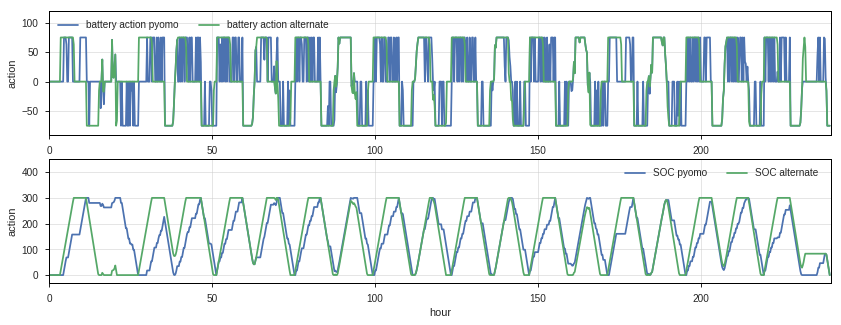

In [43]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(211)
l1, = ax1.plot(hrs,np.sum(outputVars[3:7,:]*4/1000, axis=0),color=colors[0])
l2, = ax1.plot(hrs,alternativeAction*4/1000,color=colors[1])
ax1.set_xlabel('hour'), ax1.set_ylabel('action')
ax1.legend([l1,l2],['battery action pyomo','battery action alternate'],ncol=2,loc='upper left')
ax1.set_xlim([0,len(load)/4]);
ax1.set_ylim([1.2*batt.discharging_power_limit/1000, 1.6*batt.charging_power_limit/1000]);

ax2 = fig.add_subplot(212)
l1, = ax2.plot(hrs,outputVars[0]/1000,color=colors[0])
l2, = ax2.plot(hrs,alternativeSOC/1000,color=colors[1])
ax2.set_xlabel('hour'), ax2.set_ylabel('action')
ax2.legend([l1,l2],['SOC pyomo','SOC alternate '],ncol=2)
ax2.set_xlim([0,len(load)/4]);
ax2.set_ylim([-0.1*batt.capacity/1000, 1.5*batt.capacity/1000]);